# Project Overview

**Objective**<br>
The main objective of this project is to create recommendation engine to recommend products to customers on the Brazilian E-Commerce platform [Olist](https://olist.com/pt-br/) using Collaborative Filtering.<br>
This is crucial to increase average spend of the customers and drive sales for the sellers and Olist itself.<br>

**Data**<br>
The datasets used here are **[The Brazilian E-Commerce Public Dataset by Olist](https://www.kaggle.com/olistbr/brazilian-ecommerce)**.<br>
The dataset contains information of 100k orders from 2016 to 2018 such as order status, price, payment and freight performance to customer location, product attributes, customers' reviews, etc.

# Problem Statement & Strategy

**Problem Statement**<br>
Some of the questions that a product recommendation engine can help to answer are:
- How to help customers find the right product?
- How to personalize the product recommendations based on customer's preferences?

**Strategy**<br>
There are **4 types of recommenders** included in this project, for **2 types of Olist customers**:
- (1) Popularity-based for **New Customers** (first time visiting the Olist platform)<br>
It recommends products that are most popular on the Olist platform.
- Collaborative filtering for **existing customers** (purchased at least a product on the Olist platform in the past)
    - (2) Customer-Customer<br>
    It recommends customers most similar to chosen customer based on product purchase history (product preferences). This will be helpful in recommending products that these similar customers purchased but chosen customer hasn't and might be interested.
    - (3) Product-Product<br>
    It recommends products most similar to chosen product based on certain criteria such as product category, price, product weight and even product name length. 
    - (4) Funk SVD (Singular Value Decomposition)<br>
    It recommends products based on the customer-product matrix and latent features, which can be think of the properties of product that customers may like or dislike. This method uses stochastic gradient descent to find the optimized customer and product matrices that can be used to predict, or provide personalised recommendations based on other similar customers and latent factors. 

# Import Libraries

In [1]:
# Import essential libraries
import os
import time
import random
import pandas as pd
import numpy as np
import pickle
from datetime import datetime

# For visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import sklearn libraries
from sklearn.model_selection import train_test_split

# Settings

In [2]:
# To view all generated results
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Widen the Jupyter Notebook as much as possible
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

# Import Data

In [3]:
# Setting the directories
cd = os.getcwd()
data_dir = cd + '\\data'

# Import review dataset and other key features such as product category and location to discover more about the reviews
review_df = pd.read_csv(data_dir + '\\olist_order_reviews_dataset.csv') # Includes data on customers' reviews
order_df = pd.read_csv(data_dir + '\\olist_orders_dataset.csv') # Includes data on all the orders made
order_item_df = pd.read_csv(data_dir + '\\olist_order_items_dataset.csv') # Includes data about the items purchased within each order
prod_df = pd.read_csv(data_dir + '\\olist_products_dataset.csv') # Includes data about the products sold by Olist
prod_trans_df = pd.read_csv(data_dir + '\\product_category_name_translation.csv') # Translates the productcategoryname to english.
cust_df = pd.read_csv(data_dir + '\\olist_customers_dataset.csv') # Includes data about the customer and its location

# Show samples, dataset info and missing values info
df_list = [review_df, order_df, order_item_df, prod_df, prod_trans_df, cust_df]
for df_ in df_list:
    # Show samples
    print(df_.head())
    print('\n')
    
    # Show dataset info
    print(df_.info())
    print('\n')
    
    # Show missing values info
    print(df_.isnull().sum())
    print('\n')

                          review_id                          order_id  review_score review_comment_title                             review_comment_message review_creation_date review_answer_timestamp
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb             4                  NaN                                                NaN  2018-01-18 00:00:00     2018-01-18 21:46:59
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33             5                  NaN                                                NaN  2018-03-10 00:00:00     2018-03-11 03:05:13
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b             5                  NaN                                                NaN  2018-02-17 00:00:00     2018-02-18 14:36:24
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b             5                  NaN              Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00     2017-04-21 22:0

In [4]:
# List each dataset and its key ID for data merging
df = order_item_df
df_list_updated = [order_df, prod_df, prod_trans_df, cust_df]
df_key_id_list = ['order_id', 'product_id', 'product_category_name', 'customer_id']

# Remove duplicates and merge with other datasets to extract key features
print(len(df)) # Get dataset row count before merging to check for any duplicates

i = 0 # Set counter to loop through the list
for df_ in df_list_updated:
    
    # Get respective key id from df_key_id_list
    id_ = df_key_id_list[i]
    print(id_)
    
    # Remove duplicates before merging
    print('Merge with df using ' + id_ + ':')
    print('\n')
    df_.drop_duplicates(subset=[id_], inplace=True)
    df = df.merge(df_, on=id_, how='left')
    
    i += 1 # Update counter

# The dataset row count should remain unchanged after merging, indicating the dataset shape remained intact
print(len(df)) 

# View data
df.head()

112650
order_id
Merge with df using order_id:


product_id
Merge with df using product_id:


product_category_name
Merge with df using product_category_name:


customer_id
Merge with df using customer_id:


112650


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,pet_shop,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,furniture_decor,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0,perfumery,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,garden_tools,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP


In [5]:
# View any missing values
df.isnull().sum()

order_id                            0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
product_category_name            1603
product_name_lenght              1603
product_description_lenght       1603
product_photos_qty               1603
product_weight_g                   18
product_length_cm                  18
product_height_cm                  18
product_width_cm                   18
product_category_name_english    1627
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_sta

# Data Cleaning

In [6]:
# Check for any duplicates
print(f'No. of duplicates based on all columns:{len(df[df.duplicated()])}')
                                                
# Check for any duplicates based on the ids
ids_list = ['order_id', 'customer_id', 'product_id', 'seller_id', 'customer_unique_id']
for id_ in ids_list:
    print(f'No. of duplicates based on {id_}: {len(df[df.duplicated(subset=id_)])}')
    
# There are duplicates based on order_id

No. of duplicates based on all columns:0
No. of duplicates based on order_id: 13984
No. of duplicates based on customer_id: 13984
No. of duplicates based on product_id: 79699
No. of duplicates based on seller_id: 109555
No. of duplicates based on customer_unique_id: 17230


In [7]:
# Check number of unique orders and stakeholders involved
for id_ in ids_list:
    print(f'No. of unique {id_}: {df[id_].nunique()}')

No. of unique order_id: 98666
No. of unique customer_id: 98666
No. of unique product_id: 32951
No. of unique seller_id: 3095
No. of unique customer_unique_id: 95420


In [8]:
# View samples of duplicated order_id
df[df.duplicated(subset='order_id')].sort_values(by='order_id').head(10)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
14,0008288aa423d2a3f00fcb17cd7d8719,2,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37,2355af7c75e7c98b43a87b2a7f210dc5,delivered,2018-02-13 22:10:21,2018-02-15 03:55:52,2018-02-20 18:23:28,2018-02-26 13:55:22,2018-03-06 00:00:00,ferramentas_jardim,57.0,366.0,2.0,1650.0,30.0,22.0,30.0,garden_tools,9e4159995424971423b98c4a8bc11529,6600,jandira,SP
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10,2e45292979b9b2700ea09560eeb0f803,delivered,2017-10-16 15:29:43,2017-10-16 16:07:52,2017-10-16 23:04:43,2017-10-27 18:43:56,2017-11-06 00:00:00,esporte_lazer,52.0,1153.0,1.0,180.0,17.0,11.0,14.0,sports_leisure,bb8a37225e0279ac8a274c9765617eaf,74663,goiania,GO
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10,2e45292979b9b2700ea09560eeb0f803,delivered,2017-10-16 15:29:43,2017-10-16 16:07:52,2017-10-16 23:04:43,2017-10-27 18:43:56,2017-11-06 00:00:00,esporte_lazer,52.0,1153.0,1.0,180.0,17.0,11.0,14.0,sports_leisure,bb8a37225e0279ac8a274c9765617eaf,74663,goiania,GO
43,001ab0a7578dd66cd4b0a71f5b6e1e41,2,0b0172eb0fd18479d29c3bc122c058c2,5656537e588803a555b8eb41f07a944b,2018-01-04 02:33:42,24.89,17.63,8bb3bef4e75a95524235cdc11a7331af,delivered,2017-12-27 00:38:47,2017-12-28 02:33:42,2017-12-28 18:09:35,2018-01-17 20:43:29,2018-01-29 00:00:00,eletronicos,53.0,265.0,2.0,150.0,22.0,13.0,15.0,electronics,d1f24d1d504e27bee13b415e40daeab0,40055,salvador,BA
44,001ab0a7578dd66cd4b0a71f5b6e1e41,3,0b0172eb0fd18479d29c3bc122c058c2,5656537e588803a555b8eb41f07a944b,2018-01-04 02:33:42,24.89,17.63,8bb3bef4e75a95524235cdc11a7331af,delivered,2017-12-27 00:38:47,2017-12-28 02:33:42,2017-12-28 18:09:35,2018-01-17 20:43:29,2018-01-29 00:00:00,eletronicos,53.0,265.0,2.0,150.0,22.0,13.0,15.0,electronics,d1f24d1d504e27bee13b415e40daeab0,40055,salvador,BA
49,001d8f0e34a38c37f7dba2a37d4eba8b,2,e67307ff0f15ade43fcb6e670be7a74c,f4aba7c0bca51484c30ab7bdc34bcdd1,2017-05-18 17:35:11,18.99,7.78,d987da9fb4086ab7c2c0f83963cd6722,delivered,2017-05-14 17:19:44,2017-05-14 17:35:11,2017-05-24 15:45:01,2017-05-26 13:14:50,2017-05-24 00:00:00,beleza_saude,47.0,1474.0,3.0,150.0,43.0,13.0,14.0,health_beauty,870a0bdc769f9a7870309036740e79ea,2929,sao paulo,SP
76,002c9def9c9b951b1bec6d50753c9891,2,2d9ff06c8870a518f5f6909774e140fb,00720abe85ba0859807595bbf045a33b,2018-05-21 17:32:03,78.00,8.90,06cf02bf583b05fd91bc8eec0f1b4c3f,delivered,2018-05-14 16:57:47,2018-05-15 17:37:51,2018-05-17 13:27:00,2018-05-18 14:37:38,2018-05-25 00:00:00,utilidades_domesticas,44.0,543.0,3.0,950.0,25.0,10.0,36.0,housewares,6bcc1cd0c7f8bffa6f67a6a1fbef5782,1255,sao paulo,SP
81,002f98c0f7efd42638ed6100ca699b42,2,880be32f4db1d9f6e2bec38fb6ac23ab,fa40cc5b934574b62717c68f3d678b6d,2017-08-10 09:30:15,44.90,7.16,75fd1fb0bb511fc71ac2b2649c02b21b,delivered,2017-08-04 09:19:10,2017-08-04 09:30:15,2017-08-04 18:09:47,2017-08-07 19:07:30,2017-09-05 00:00:00,brinquedos,45.0,589.0,4.0,200.0,16.0,7.0,11.0,toys,2e875ea57961ad115cec13fef0920ae6,91910,porto alegre,RS
88,003324c70b19a16798817b2b3640e721,2,2b939dc9b176d7fa21594d588815d4a4,dbc22125167c298ef99da25668e1011f,2017-05-24 19:22:34,102.90,14.45,43696894b5bf8fbe1a40b2148ea505a0,delivered,2017-05-18 19:04:48,2017-05-18 19:22:34,2017-05-19 16:04:55,2017-05-30 08:12:15,2017-06-07 00:00:00,malas_acessorios,45.0,702.0,1.0,1300.0,33.0,10.0,49.0,luggage_accessories,f

In [9]:
# View dataset of first 3 samples
df[df['order_id'].isin(['0008288aa423d2a3f00fcb17cd7d8719', '00143d0f86d6fbd9f9b38ab440ac16f5', '001ab0a7578dd66cd4b0a71f5b6e1e41'])]

# The order_id has duplicates due to the same product being purchased multiple times, as indicated by order_item_id
# For this project, such duplicates would be removed as main objective is to recommend the product and not the count
# Thus, removing such duplicates will not impact the quality of the recommendations

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
13,0008288aa423d2a3f00fcb17cd7d8719,1,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37,2355af7c75e7c98b43a87b2a7f210dc5,delivered,2018-02-13 22:10:21,2018-02-15 03:55:52,2018-02-20 18:23:28,2018-02-26 13:55:22,2018-03-06 00:00:00,ferramentas_jardim,57.0,366.0,2.0,1650.0,30.0,22.0,30.0,garden_tools,9e4159995424971423b98c4a8bc11529,6600,jandira,SP
14,0008288aa423d2a3f00fcb17cd7d8719,2,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37,2355af7c75e7c98b43a87b2a7f210dc5,delivered,2018-02-13 22:10:21,2018-02-15 03:55:52,2018-02-20 18:23:28,2018-02-26 13:55:22,2018-03-06 00:00:00,ferramentas_jardim,57.0,366.0,2.0,1650.0,30.0,22.0,30.0,garden_tools,9e4159995424971423b98c4a8bc11529,6600,jandira,SP
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10,2e45292979b9b2700ea09560eeb0f803,delivered,2017-10-16 15:29:43,2017-10-16 16:07:52,2017-10-16 23:04:43,2017-10-27 18:43:56,2017-11-06 00:00:00,esporte_lazer,52.0,1153.0,1.0,180.0,17.0,11.0,14.0,sports_leisure,bb8a37225e0279ac8a274c9765617eaf,74663,goiania,GO
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10,2e45292979b9b2700ea09560eeb0f803,delivered,2017-10-16 15:29:43,2017-10-16 16:07:52,2017-10-16 23:04:43,2017-10-27 18:43:56,2017-11-06 00:00:00,esporte_lazer,52.0,1153.0,1.0,180.0,17.0,11.0,14.0,sports_leisure,bb8a37225e0279ac8a274c9765617eaf,74663,goiania,GO
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10,2e45292979b9b2700ea09560eeb0f803,delivered,2017-10-16 15:29:43,2017-10-16 16:07:52,2017-10-16 23:04:43,2017-10-27 18:43:56,2017-11-06 00:00:00,esporte_lazer,52.0,1153.0,1.0,180.0,17.0,11.0,14.0,sports_leisure,bb8a37225e0279ac8a274c9765617eaf,74663,goiania,GO
42,001ab0a7578dd66cd4b0a71f5b6e1e41,1,0b0172eb0fd18479d29c3bc122c058c2,5656537e588803a555b8eb41f07a944b,2018-01-04 02:33:42,24.89,17.63,8bb3bef4e75a95524235cdc11a7331af,delivered,2017-12-27 00:38:47,2017-12-28 02:33:42,2017-12-28 18:09:35,2018-01-17 20:43:29,2018-01-29 00:00:00,eletronicos,53.0,265.0,2.0,150.0,22.0,13.0,15.0,electronics,d1f24d1d504e27bee13b415e40daeab0,40055,salvador,BA
43,001ab0a7578dd66cd4b0a71f5b6e1e41,2,0b0172eb0fd18479d29c3bc122c058c2,5656537e588803a555b8eb41f07a944b,2018-01-04 02:33:42,24.89,17.63,8bb3bef4e75a95524235cdc11a7331af,delivered,2017-12-27 00:38:47,2017-12-28 02:33:42,2017-12-28 18:09:35,2018-01-17 20:43:29,2018-01-29 00:00:00,eletronicos,53.0,265.0,2.0,150.0,22.0,13.0,15.0,electronics,d1f24d1d504e27bee13b415e40daeab0,40055,salvador,BA
44,001ab0a7578dd66cd4b0a71f5b6e1e41,3,0b0172eb0fd18479d29c3bc122c058c2,5656537e588803a555b8eb41f07a944b,2018-01-04 02:33:42,24.89,17.63,8bb3bef4e75a95524235cdc11a7331af,delivered,2017-12-27 00:38:47,2017-12-28 02:33:42,2017-12-28 18:09:35,2018-01-17 20:43:29,2018-01-29 00:00:00,eletronicos,53.0,265.0,2.0,150.0,22.0,13.0,15.0,electronics,d1f24d1d504e27bee13b415e40daeab0,40055,salvador,BA


In [10]:
# Remove duplicates
df.drop_duplicates(subset=['order_id'], inplace=True)
df.drop(columns='order_item_id', inplace=True)
print(f'Row count after removing duplicates: {len(df)}')

# View data
df.head()

Row count after removing duplicates: 98666


,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,pet_shop,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,furniture_decor,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0,perfumery,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,garden_tools,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP


# Explatory Data Analysis (EDA)

## Product Categories

<AxesSubplot:title={'center':'Order Count'}, ylabel='product_category_name_english'>

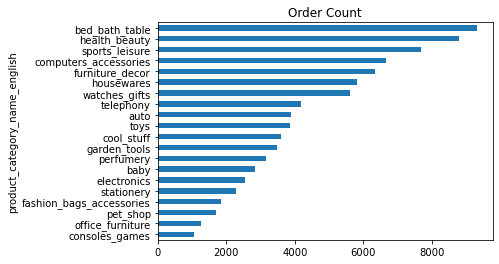

In [11]:
# View distribution (Top 20)
df.groupby('product_category_name_english')['order_id'].count().sort_values().tail(20).plot(kind='barh', title='Order Count')

<AxesSubplot:title={'center':'Sales'}, ylabel='product_category_name_english'>

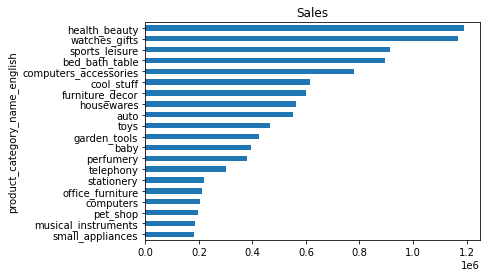

In [12]:
# View distribution (Top 20)
df.groupby('product_category_name_english')['price'].sum().sort_values().tail(20).plot(kind='barh', title='Sales')

<AxesSubplot:title={'center':'Unique Product Count'}, ylabel='product_category_name_english'>

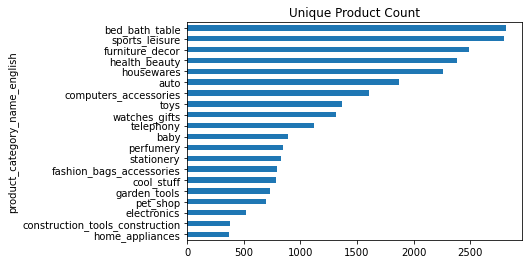

In [13]:
# View distribution (Top 20)
df.groupby('product_category_name_english')['product_id'].nunique().sort_values().tail(20).plot(kind='barh', title='Unique Product Count')

In [14]:
# Let's focus only on top 3 categories with most sales
top_5_sales_cat = list(df.groupby('product_category_name_english')['price'].sum().sort_values().tail(3).index)
df = df[df['product_category_name_english'].isin(top_5_sales_cat)]
df['product_category_name_english'].value_counts()

health_beauty     8796
sports_leisure    7681
watches_gifts     5601
Name: product_category_name_english, dtype: int64

## Customer States

22078
22078


<AxesSubplot:title={'center':'Order Count'}, ylabel='customer_state_desc'>

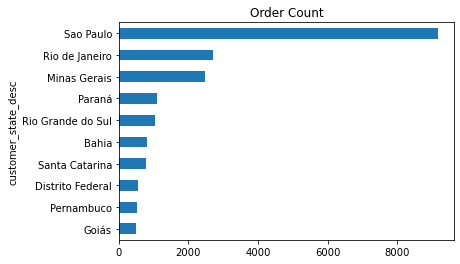

In [15]:
# Import table
state_desc_df = pd.read_excel(data_dir + '\\customer_state_name.xlsx')

# Merge with df
print(len(df))
state_desc_df.drop_duplicates(subset=['customer_state'], inplace=True)
df = df.merge(state_desc_df, on='customer_state', how='left')
print(len(df))

# View distribution
df.groupby('customer_state_desc')['order_id'].count().sort_values().tail(10).plot(kind='barh', title='Order Count')

<AxesSubplot:title={'center':'Sales'}, ylabel='customer_state_desc'>

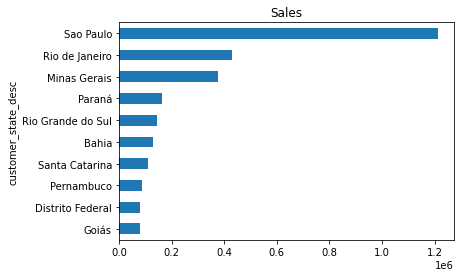

In [16]:
# View distribution
df.groupby('customer_state_desc')['price'].sum().sort_values().tail(10).plot(kind='barh', title='Sales')

## Customer Cities

<AxesSubplot:title={'center':'Order Count'}, ylabel='customer_city'>

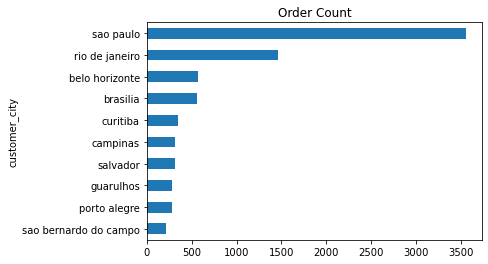

In [17]:
# View distribution
df.groupby('customer_city')['order_id'].count().sort_values().tail(10).plot(kind='barh', title='Order Count')

<AxesSubplot:title={'center':'Sales'}, ylabel='customer_city'>

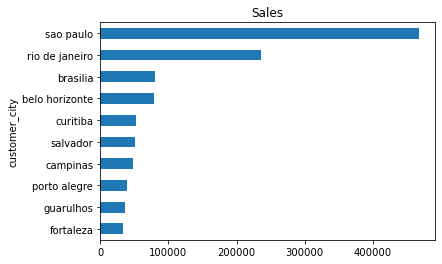

In [18]:
# View distribution
df.groupby('customer_city')['price'].sum().sort_values().tail(10).plot(kind='barh', title='Sales')

## Purchase Year-Month

<AxesSubplot:title={'center':'Order Count'}, xlabel='order_purchase_year_month'>

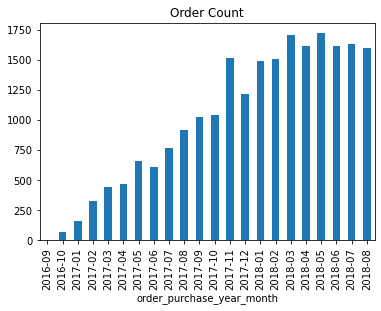

In [19]:
# View distribution
df['order_purchase_year_month'] = df['order_purchase_timestamp'].str[:7]
df.groupby('order_purchase_year_month')['order_id'].count().sort_index().plot(kind='bar', title='Order Count')

# There has been a steady rise from Sep 2016 until Oct 2017, before a spike in Nov 2017 that levels up Olist's orders afterwards

<AxesSubplot:title={'center':'Sales'}, xlabel='order_purchase_year_month'>

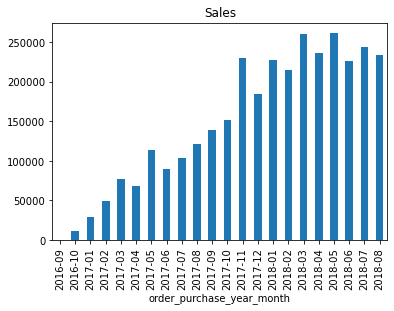

In [20]:
# View distribution
df.groupby('order_purchase_year_month')['price'].sum().sort_index().plot(kind='bar', title='Sales')

## Purchase Hour

<AxesSubplot:title={'center':'Order Count'}, xlabel='order_purchase_hour'>

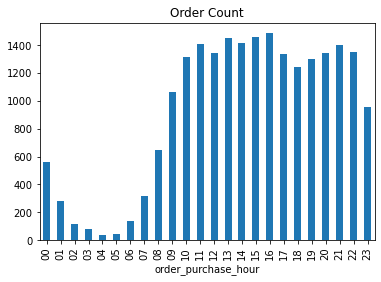

In [21]:
# View distribution
df['order_purchase_hour'] = df['order_purchase_timestamp'].str[11:13]
df.groupby('order_purchase_hour')['order_id'].count().sort_index().plot(kind='bar', title='Order Count')

# Most orders are placed during working hours after lunch and before working time ends

<AxesSubplot:title={'center':'Sales'}, xlabel='order_purchase_hour'>

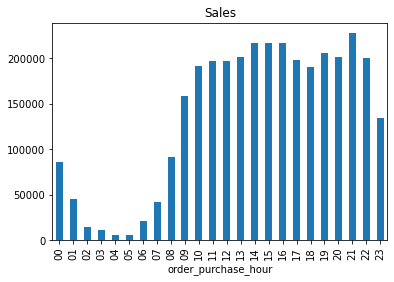

In [22]:
# View distribution
df.groupby('order_purchase_hour')['price'].sum().sort_index().plot(kind='bar', title='Sales')

## Rank-Based Recommendations

Get top N product (ids) based on its popularity i.e., number of orders made that include the product. This will be useful in recommending products to new customers.

In [23]:
# Simplify product_id and customer_unique_id
simplify_ids = ['product_id', 'customer_unique_id']

for id_ in simplify_ids:
    
    # Create placeholder for original id
    ori_id_ = id_ + '_ori' 
    df[ori_id_] = df[id_]
    df.drop(columns=id_, inplace=True)
    
    # Create pivot table with original ID as index where each original ID is unique
    temp = pd.pivot_table(df, index=ori_id_, values='order_id', aggfunc='count').reset_index()
    temp[id_] = np.arange(len(temp)) + 1 # new ID starts with 1
    temp.drop(columns='order_id', inplace=True)
    
    # Merge with df
    df = df.merge(temp, on=ori_id_, how='left')

# View data
df.head(10)

,order_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,customer_zip_code_prefix,customer_city,customer_state,customer_state_desc,order_purchase_year_month,order_purchase_hour,product_id_ori,product_id,customer_unique_id_ori,customer_unique_id
0,0005a1a1728c9d785b8e2b08b904576c,a416b6a846a11724393025641d4edd5e,2018-03-26 18:31:29,145.95,11.65,16150771dfd4776261284213b89c304e,delivered,2018-03-19 18:40:33,2018-03-20 18:35:21,2018-03-28 00:37:42,2018-03-29 18:17:31,2018-03-29 00:00:00,beleza_saude,59.0,493.0,1.0,2000.0,30.0,12.0,16.0,health_beauty,11075,santos,SP,Sao Paulo,2018-03,18,310ae3c140ff94b03219ad0adc3c778f,1238,639d23421f5517f69d0c3d6e6564cf0e,8417
1,00061f2a7bc09da83e415a52dc8a4af1,cc419e0650a3c5ba77189a1882b7556a,2018-03-29 22:28:09,59.99,8.88,c6fc061d86fab1e2b2eac259bac71a49,delivered,2018-03-24 22:16:10,2018-03-24 22:28:09,2018-03-27 05:26:55,2018-03-29 00:04:19,2018-04-09 00:00:00,beleza_saude,57.0,614.0,1.0,950.0,35.0,25.0,20.0,health_beauty,13419,piracicaba,SP,Sao Paulo,2018-03,22,d63c1011f49d98b976c352955b1c4bea,5461,107e6259485efac66428a56f10801f4f,1397
2,0009792311464db532ff765bf7b182ae,530ec6109d11eaaf87999465c6afee01,2018-08-17 12:15:10,99.90,27.65,2a30c97668e81df7c17a8b14447aeeba,delivered,2018-08-14 20:43:09,2018-08-15 12:15:10,2018-08-15 15:28:00,2018-08-22 12:02:27,2018-08-28 00:00:00,esporte_lazer,56.0,1392.0,4.0,1050.0,40.0,20.0,30.0,sports_leisure,37137,alfenas,MG,Minas Gerais,2018-08,20,8cab8abac59158715e0d70a36c807415,3528,4987996ddcd0ddb20740fdce7c2bfbb1,6222
3,000c3e6612759851cc3cbb4b83257986,218d46b86c1881d022bce9c68a7d4b15,2017-08-21 03:33:13,99.00,13.71,3773bcf1a6fbd29233ea1c1b573c4f22,delivered,2017-08-12 10:08:57,2017-08-15 03:35:32,2017-08-15 15:32:51,2017-08-19 15:22:17,2017-09-01 00:00:00,esporte_lazer,58.0,2584.0,1.0,1800.0,16.0,16.0,16.0,sports_leisure,13208,jundiai,SP,Sao Paulo,2017-08,10,b50c950aba0dcead2c48032a690ce817,4545,f5f088001070650f9e9a8cd773621f35,20698
4,00119ff934e539cf26f92b9ef0cdfed8,c864036feaab8c1659f65ea4faebe1da,2017-08-11 00:35:12,219.90,16.98,7dd2e283f47deac853cf70f3b63c8d86,delivered,2017-08-06 00:42:49,2017-08-07 00:35:12,2017-08-07 21:12:34,2017-08-16 17:29:59,2017-08-31 00:00:00,esporte_lazer,35.0,1132.0,8.0,9800.0,105.0,15.0,28.0,sports_leisure,26263,nova iguacu,RJ,Rio de Janeiro,2017-08,00,21b1c2f67a9aafb5af0eb06c13b9dbda,880,13df7b623839b4edc579ee40279d57c8,1672
5,00143d0f86d6fbd9f9b38ab440ac16f5,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10,2e45292979b9b2700ea09560eeb0f803,delivered,2017-10-16 15:29:43,2017-10-16 16:07:52,2017-10-16 23:04:43,2017-10-27 18:43:56,2017-11-06 00:00:00,esporte_lazer,52.0,1153.0,1.0,180.0,17.0,11.0,14.0,sports_leisure,74663,goiania,GO,Goiás,2017-10,15,e95ee6822b66ac6058e2e4aff656071a,5921,bb8a37225e0279ac8a274c9765617eaf,15777
6,001d8f0e34a38c37f7dba2a37d4eba8b,f4aba7c0bca51484c30ab7bdc34bcdd1,2017-05-18 17:35:11,18.99,7.78,d987da9fb4086ab7c2c0f83963cd6722,delivered,2017-05-14 17:19:44,2017-05-14 17:35:11,2017-05-24 15:45:01,2017-05-26 13:14:50,2017-05-24 00:00:00,beleza_saude,47.0,1474.0,3.0,150.0,43.0,13.0,14.0,health_beauty,2929,sao paulo,SP,Sao Paulo,2017-05,17,e67307ff0f15ade43fcb6e670be7a74c,5862,870a0bdc769f9a7870309036740e79ea,11349
7,001e7cf2ad6bef3ade12ebc56ceaf0f3,2a84855fd20af891be03bc5924d2b453,2018-05-22 10:59:50,35.90,15.20,d1684ed69f8fd574b7c344de923f379a,delivered,2018-05-19 10:29:23,2018-05-19 10:59:50,2018-05-21 14:34:00,2018-06-04 18:08:23,2018-06-05 00:00:00,beleza_saude,26.0,394.0,1.0,1614.0,31.0,16.0,28.0,health_beauty,38550,coromandel,MG,Minas Gerais,2018-05,10,bdcf6a834e8faa30dac3886c7a58e92e,4763,43860f86362fea12550bfa19ef73015f,5654
8,00229e4

In [24]:
# Function to get top N most popular products
def get_top_product_ids(n, df=df):
    
    '''
    INPUT:
    n - (int) the number of top products to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_products - (list) A list of the top 'n' products 
    
    '''
    
    # Count number of customer orders with the product
    product_count_table = df.groupby(['product_id'])['customer_unique_id'].count()
    product_count_table = product_count_table.nlargest(n)
    
    # Get top n products based on number of customer orders
    top_product_ids = list(product_count_table.index)  
 
    return top_product_ids # Return the top product ids

In [25]:
# Test Top 10 product_id
print(df.groupby(['product_id'])['customer_unique_id'].count().sort_values(ascending=False).head(10))
print('\n')
print(get_top_product_ids(10))

product_id
2062    302
563     267
1099    257
3101    222
5728    190
4709    187
4139    172
4228    156
668     155
2705    150
Name: customer_unique_id, dtype: int64


[2062, 563, 1099, 3101, 5728, 4709, 4139, 4228, 668, 2705]


## Customer-Customer Based Collaborative Filtering

Provide recommendations based on other customers most similar to chosen customer. Below are the structure of customer-product matrix:
- Each **customer** should only appear in each **row** once.
- Each **product** should only show up in one **column**.  
- **If a customer has purchased a product, then place a 1 where the customer-row meets for that product-column**.<br>
It does not matter how many times a customer has purchased the product, all entries where a customer has purchased a product should be a 1.  
- **If a customer has not purchased a product, then place a zero where the customer-row meets for that product-column**. 

In [26]:
# create the customer-product matrix with 1's and 0's
def create_customer_product_matrix(df):
    
    '''
    INPUT:
    df - pandas dataframe with product_id and customer_unique_id columns
    
    OUTPUT:
    customer_product - customer item matrix 
    
    Description:
    Return a matrix with customer ids as rows and product ids on the columns with 1 values where a customer purchased 
    a product and a 0 otherwise
    '''
    
    customer_product = df.groupby(['customer_unique_id', 'product_id'])['product_id'].nunique().unstack()
    
    return customer_product # return the customer_product matrix 

customer_product = create_customer_product_matrix(df)
customer_product

product_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,...,6444,6445,6446,6447,6448,6449,6450,6451,6452,6453,6454,6455,6456,6457,6458,6459,6460,6461,6462,6463,6464,6465,6466,6467,6468,6469,6470,6471,6472,6473,6474,6475,6476,6477,6478,6479,6480,6481,6482,6483,6484,6485,6486,6487,6488,6489,6490,6491,6492,6493
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Na

In [27]:
# View dataframe shape
print(customer_product.shape)

# View number of products seen by customer 1 
customer_product.sum(axis=1)[1]

(21591, 6493)


1.0

Create a function that takes a customer_unique_id and provide an ordered list of the most similar customers to that customer (from most similar to least similar).<br>
The returned result should not contain the provided customer_unique_id, as we know that each customer is similar to him/herself. Because the results for each customer here are binary, it makes sense to compute similarity as the dot product of two customers. 

In [28]:
def find_similar_customers(customer_unique_id, customer_product=customer_product):
    
    '''
    INPUT:
    customer_unique_id - (int) a customer_unique_id
    customer_product - (pandas dataframe) matrix of customers by products: 
                1's when a customer has purchased a product, 0 otherwise
    
    OUTPUT:
    similar_customers - (list) an ordered list where the closest customers (largest dot product customers)
                    are listed first
    
    Description:
    Computes the similarity of every pair of customers based on the dot product
    Returns an ordered list
    
    '''
    
    # compute similarity of each customer to the provided customer
    most_similar_customers = (customer_product * customer_product.loc[customer_unique_id].transpose()).sum(axis=1)

    # sort by similarity
    most_similar_customers = most_similar_customers.sort_values(ascending=False)
    
    # remove the own customer's id
    most_similar_customers = most_similar_customers.drop(customer_unique_id)
    
    # create list of just the ids 
    most_similar_customers = list(most_similar_customers.index)
       
    return most_similar_customers # return a list of the customers in order from most to least similar

In [29]:
# Test function
print("The 3 most similar customers to customer 69 are: {}".format(find_similar_customers(69)[:3]))
print("The 5 most similar customers to customer 96 are: {}".format(find_similar_customers(96)[:5]))
print("The 10 most similar customers to customer 696 are: {}".format(find_similar_customers(696)[:10]))

The 3 most similar customers to customer 69 are: [15767, 5975, 3326]
The 5 most similar customers to customer 96 are: [12440, 17840, 21528, 959, 16095]
The 10 most similar customers to customer 696 are: [17549, 12274, 10952, 19044, 3888, 21405, 9675, 6521, 2999, 308]


## Product-Product Based Collaborative Filtering

Product recommendation here is based on most similar features. It requires a matrix of product and its features such as price bracket and length etc.<br>
Similar to Customer-Customer Collaborative Filtering, it uses the dot product of itself to list out recommended products in decreasing order of similarity.

              price  product_name_lenght  product_description_lenght  product_weight_g  product_length_cm  product_height_cm  product_width_cm
count  22078.000000         22078.000000                22078.000000      22078.000000       22078.000000       22078.000000      22078.000000
mean     148.190402            48.006205                  985.692409       1197.169309          25.282227          14.221487         18.259172
std      205.035086            10.270051                  800.770675       2799.685135          14.461656          10.464159          7.824370
min        1.200000             9.000000                   33.000000         50.000000          11.000000           2.000000          6.000000
25%       49.900000            41.000000                  476.000000        250.000000          17.000000          10.000000         14.000000
50%       95.000000            50.000000                  696.000000        444.000000          20.000000          12.000000         16.000000

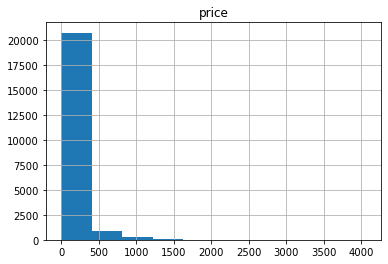

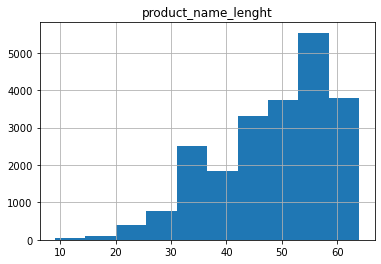

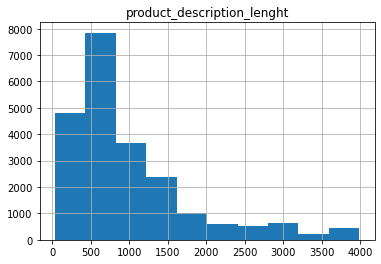

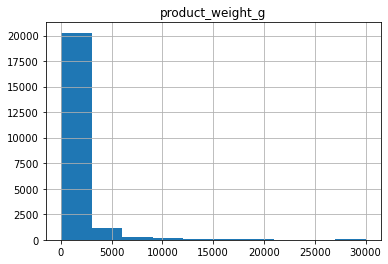

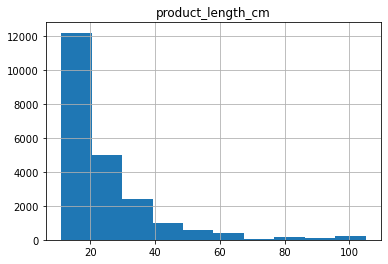

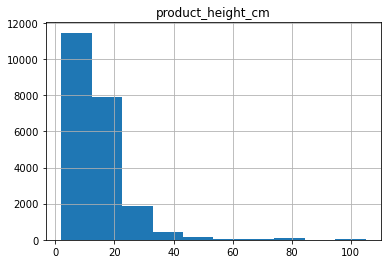

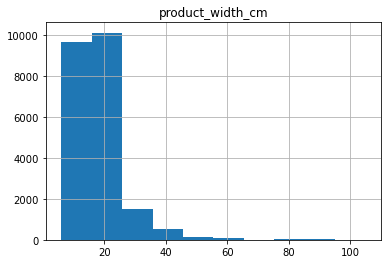

In [30]:
# List key product features
prod_features = ['price', 'product_name_lenght', 'product_description_lenght', 'product_weight_g', 
                 'product_length_cm', 'product_height_cm', 'product_width_cm']

# View numerical summary
print(df[prod_features].describe())

# View distribution
for feature in prod_features:
    df[feature].hist()
    plt.title(feature)
    plt.show()

### Group key numerical values together
- Product category: Whether products are similar in nature
- Price: It is an important consideration during purchase
- Product weight: It considers the form factor of the products and its delivery fee charge
- Product name: Longer names may confuse customers, and established brands may require shorter name to market itself

In [31]:
# Grouping of price
def PRICE_GRP(x):
    if(x <= 50):
        return('a_50_below')
    elif(x > 50) & (x <= 100):
        return('b_50_100')
    elif(x > 100) & (x <= 150):
        return('c_100_150')
    else:
        return('d_above_150')
    
df['price_grp'] = df['price'].apply(PRICE_GRP)
df['price_grp'].value_counts().sort_index()

a_50_below     5786
b_50_100       6236
c_100_150      4127
d_above_150    5929
Name: price_grp, dtype: int64

In [32]:
# Grouping of product weight
def WEIGHT_GRP(x):
    if(x <= 250):
        return('a_250_below')
    elif(x > 250) & (x <= 500):
        return('b_250_500')
    elif(x > 500) & (x <= 750):
        return('c_500_750')
    elif(x > 750) & (x <= 1000):
        return('d_750_1000')
    else:
        return('e_above_1000')
    
df['product_weight_grp'] = df['product_weight_g'].apply(WEIGHT_GRP)
df['product_weight_grp'].value_counts().sort_index()

a_250_below     6206
b_250_500       6073
c_500_750       2623
d_750_1000      1565
e_above_1000    5611
Name: product_weight_grp, dtype: int64

In [33]:
# Grouping of product name
def NAME_LEN_GRP(x):
    if(x <= 35):
        return('a_35_below')
    elif(x > 35) & (x <= 40):
        return('b_35_40')
    elif(x > 40) & (x <= 45):
        return('c_40_45')
    elif(x > 45) & (x <= 50):
        return('d_45_50')
    elif(x > 50) & (x <= 55):
        return('e_50_55')
    else:
        return('f_above_55')
    
df['product_name_length_grp'] = df['product_name_lenght'].apply(NAME_LEN_GRP)
df['product_name_length_grp'].value_counts().sort_index()

a_35_below    3598
b_35_40       1594
c_40_45       2581
d_45_50       3638
e_50_55       3720
f_above_55    6947
Name: product_name_length_grp, dtype: int64

In [34]:
# Combine the features to ease one-hot encoding
df['key_prod_features'] = df['product_category_name_english'] + ' ' + df['price_grp'] + ' ' + df['product_weight_grp'] + ' ' + df['product_name_length_grp']

# Create the product matrix
products_mat = df.groupby(['product_id', 'key_prod_features'])['key_prod_features'].nunique().unstack()

# View data
products_mat

key_prod_features,health_beauty a_50_below a_250_below a_35_below,health_beauty a_50_below a_250_below b_35_40,health_beauty a_50_below a_250_below c_40_45,health_beauty a_50_below a_250_below d_45_50,health_beauty a_50_below a_250_below e_50_55,health_beauty a_50_below a_250_below f_above_55,health_beauty a_50_below b_250_500 a_35_below,health_beauty a_50_below b_250_500 b_35_40,health_beauty a_50_below b_250_500 c_40_45,health_beauty a_50_below b_250_500 d_45_50,health_beauty a_50_below b_250_500 e_50_55,health_beauty a_50_below b_250_500 f_above_55,health_beauty a_50_below c_500_750 a_35_below,health_beauty a_50_below c_500_750 b_35_40,health_beauty a_50_below c_500_750 c_40_45,health_beauty a_50_below c_500_750 d_45_50,health_beauty a_50_below c_500_750 e_50_55,health_beauty a_50_below c_500_750 f_above_55,health_beauty a_50_below d_750_1000 a_35_below,health_beauty a_50_below d_750_1000 b_35_40,health_beauty a_50_below d_750_1000 c_40_45,health_beauty a_50_below d_750_1000 d_45_50,health_beauty a_50_below d_750_1000 e_50_55,health_beauty a_50_below d_750_1000 f_above_55,health_beauty a_50_below e_above_1000 a_35_below,health_beauty a_50_below e_above_1000 b_35_40,health_beauty a_50_below e_above_1000 c_40_45,health_beauty a_50_below e_above_1000 d_45_50,health_beauty a_50_below e_above_1000 e_50_55,health_beauty a_50_below e_above_1000 f_above_55,health_beauty b_50_100 a_250_below a_35_below,health_beauty b_50_100 a_250_below b_35_40,health_beauty b_50_100 a_250_below c_40_45,health_beauty b_50_100 a_250_below d_45_50,health_beauty b_50_100 a_250_below e_50_55,health_beauty b_50_100 a_250_below f_above_55,health_beauty b_50_100 b_250_500 a_35_below,health_beauty b_50_100 b_250_500 b_35_40,health_beauty b_50_100 b_250_500 c_40_45,health_beauty b_50_100 b_250_500 d_45_50,health_beauty b_50_100 b_250_500 e_50_55,health_beauty b_50_100 b_250_500 f_above_55,health_beauty b_50_100 c_500_750 a_35_below,health_beauty b_50_100 c_500_750 b_35_40,health_beauty b_50_100 c_500_750 c_40_45,health_beauty b_50_100 c_500_750 d_45_50,health_beauty b_50_100 c_500_750 e_50_55,health_beauty b_50_100 c_500_750 f_above_55,health_beauty b_50_100 d_750_1000 a_35_below,health_beauty b_50_100 d_750_1000 b_35_40,...,watches_gifts c_100_150 b_250_500 a_35_below,watches_gifts c_100_150 b_250_500 b_35_40,watches_gifts c_100_150 b_250_500 c_40_45,watches_gifts c_100_150 b_250_500 d_45_50,watches_gifts c_100_150 b_250_500 e_50_55,watches_gifts c_100_150 b_250_500 f_above_55,watches_gifts c_100_150 c_500_750 a_35_below,watches_gifts c_100_150 c_500_750 b_35_40,watches_gifts c_100_150 c_500_750 c_40_45,watches_gifts c_100_150 c_500_750 d_45_50,watches_gifts c_100_150 c_500_750 e_50_55,watches_gifts c_100_150 c_500_750 f_above_55,watches_gifts c_100_150 d_750_1000 a_35_below,watches_gifts c_100_150 d_750_1000 d_45_50,watches_gifts c_100_150 d_750_1000 f_above_55,watches_gifts c_100_150 e_above_1000 a_35_below,watches_gifts c_100_150 e_above_1000 b_35_40,watches_gifts c_100_150 e_above_1000 d_45_50,watches_gifts c_100_150 e_above_1000 e_50_55,watches_gifts c_100_150 e_above_1000 f_above_55,watches_gifts d_above_150 a_250_below a_35_below,watches_gifts d_above_150 a_250_below b_35_40,watches_gifts d_above_150 a_250_below c_40_45,watches_gifts d_above_150 a_250_below d_45_50,watches_gifts d_above_150 a_250_below e_50_55,watches_gifts d_above_150 a_250_below f_above_55,watches_gifts d_above_150 b_250_500 a_35_below,watches_gifts d_above_150 b_250_500 b_35_40,watches_gifts d_above_150 b_250_500 c_40_45,watches_gifts d_above_150 b_250_500 d_45_50,watches_gifts d_above_150 b_250_500 e_50_55,watches_gifts d_above_150 b_250_500 f_above_55,watches_gifts d_above_150 c_500_750 a_35_below,watches_gifts d_above_150 c_500_750 b_35_40,watches_gifts d_above_150 c_500_750 c_40_45,watches_gifts d_above_150 c_500_750 d_45_50,watches_gifts d_above_150 c_500_750 e_50_55,watches_gifts d_above_150 c_500_750 f_above_55,watches_gifts d_above_150 d_750_1000 a_35_below,watches_gifts d

In [35]:
def find_similar_products(product_id, products_mat=products_mat):
    
    '''
    INPUT:
    product_id - (int) a product_id
    products_mat - (pandas dataframe) matrix of products by product features: 
                   1's when a product has the combination of features, 0 otherwise
    
    OUTPUT:
    similar_products - (list) an ordered list where the closest products are listed first
                        closest in terms of similarity based on price, product weight and product name
    
    Description:
    Computes the similarity of every pair of products based on the dot product
    Returns an ordered list
    
    '''
    
    # compute similarity of each product to the provided product
    most_similar_products = (products_mat * products_mat.loc[product_id].transpose()).sum(axis=1)

    # sort by similarity
    most_similar_products = most_similar_products.sort_values(ascending=False)
    
    # remove the own product's id
    most_similar_products = most_similar_products.drop(product_id)
    
    # create list of just the ids 
    most_similar_products = list(most_similar_products.index)
       
    return most_similar_products # return a list of the products in order from most to least similar

In [36]:
# Test function
print("The 3 most similar products to product 69 are: {}".format(find_similar_products(69)[:3]))
print("The 5 most similar products to product 96 are: {}".format(find_similar_products(96)[:5]))
print("The 10 most similar products to product 696 are: {}".format(find_similar_products(696)[:10]))

The 3 most similar products to product 69 are: [1226, 172, 5822]
The 5 most similar products to product 96 are: [236, 3411, 4424, 2397, 1110]
The 10 most similar products to product 696 are: [1327, 5030, 5347, 5346, 4940, 2585, 5213, 5735, 4925, 3103]


In [37]:
# View samples and determine if the product category, price, weight and name length are similar
similar_prod_id = find_similar_products(96)[:5]
df[['product_id', 'product_category_name_english', 'price', 'product_weight_g', 'product_name_lenght']][df['product_id'].isin(similar_prod_id + [96])].sort_values(by='product_id')

# The samples seem similar to chosen product ID in terms of product features used

,product_id,product_category_name_english,price,product_weight_g,product_name_lenght
5935,96,sports_leisure,229.00,500.0,48.0
19765,236,sports_leisure,168.00,350.0,50.0
10698,1110,sports_leisure,209.99,400.0,50.0
7164,2397,sports_leisure,195.00,497.0,46.0
1362,3411,sports_leisure,189.00,500.0,50.0
1548,4424,sports_leisure,109.99,383.0,46.0
7616,4424,sports_leisure,183.90,383.0,46.0


## Matrix Factorization - Funk SVD

In [38]:
# Split into train and test datasets
df_train, df_test = train_test_split(df, test_size=0.25, random_state=69)
customer_product_train = create_customer_product_matrix(df_train)
customer_product_test = create_customer_product_matrix(df_test)

In [39]:
# Create the Funk SVD function
def FunkSVD(customer_product, latent_features=5, learning_rate=0.005, iters=100):
    
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    customer_product - (numpy array) a matrix with customers as rows, products as columns, and ratings as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    customer_mat - (numpy array) a customer by latent feature matrix
    product_mat - (numpy array) a latent feature by product matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_customers = customer_product.shape[0]
    n_products = customer_product.shape[1]
    num_purchase = np.count_nonzero(~np.isnan(customer_product))
    
    # Initialize the customer and product matrices with random values
    customer_mat = np.random.rand(n_customers, latent_features)
    product_mat = np.random.rand(latent_features, n_products)
    
    # Initialize sum of squared error ('sse') at 0 for first iteration
    sse_accum = 0
    
    # Header for verbose
    print('Optimizaiton Statistics')
    print('Iterations | Mean Squared Error')
    
    # Loop through each iteration
    for iteration in range(iters):

        # Update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each customer-product pair
        for i in range(n_customers):
            for j in range(n_products):
                
                # If the purchase exists
                if customer_product[i, j] > 0:
                    
                    # Compute the error as the actual minus the dot product of the customer and product latent features
                    diff = customer_product[i, j] - np.dot(customer_mat[i, :], product_mat[:, j])
                    
                    # Calculate and sum the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # Update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        customer_mat[i, k] += learning_rate * (2 * diff * product_mat[k, j])
                        product_mat[k, j] += learning_rate * (2 * diff * customer_mat[i, k])

        # Show results for iteration
        print('%d \t\t %f' % (iteration+1, sse_accum / num_purchase))
        
        # Early stopping (minimum iteration of 15) if improvements is below 3%
        if iteration > 15 and abs((sse_accum / old_sse) - 1) < 0.03:
            print('Model run stopped early due to insignificant improvements')
            break
            
        
    return customer_mat, product_mat 

In [40]:
# Test Funk SVD on the matrix with the missing value
customer_mat, product_mat = FunkSVD(customer_product_train.values)

Optimizaiton Statistics
Iterations | Mean Squared Error
1 		 0.268023
2 		 0.213507
3 		 0.184352
4 		 0.163101
5 		 0.146445
6 		 0.132886
7 		 0.121566
8 		 0.111938
9 		 0.103632
10 		 0.096382
11 		 0.089992
12 		 0.084315
13 		 0.079235
14 		 0.074662
15 		 0.070523
16 		 0.066759
17 		 0.063321
18 		 0.060169
19 		 0.057269
20 		 0.054592
21 		 0.052114
22 		 0.049814
23 		 0.047674
24 		 0.045678
25 		 0.043812
26 		 0.042064
27 		 0.040424
28 		 0.038883
29 		 0.037431
30 		 0.036062
31 		 0.034769
32 		 0.033546
33 		 0.032388
34 		 0.031289
35 		 0.030246
36 		 0.029254
37 		 0.028311
38 		 0.027412
39 		 0.026554
40 		 0.025736
41 		 0.024954
42 		 0.024206
Model run stopped early due to insignificant improvements


In [41]:
# Show customer and product matrices generated by Funk SVD
print(customer_mat.shape); print(customer_mat)
print('\n')
print(product_mat.shape); print(product_mat)

(16292, 5)
[[0.67310796 0.09641881 0.60803083 0.89306375 0.52510487]
 [0.61843294 0.92085941 0.38408976 0.57942461 0.08185881]
 [0.86510832 0.36681046 0.44637704 0.39906525 0.13003773]
 ...
 [0.24160814 0.7920048  0.38352115 0.89599746 0.29584652]
 [0.7853126  0.49026542 0.49514987 0.21210855 0.395663  ]
 [0.52320764 0.50729286 0.13893709 0.33729249 0.65940697]]


(5, 5481)
[[ 0.37942443  0.66099579  0.42380836 ...  0.02472299  0.59933823
   0.71281923]
 [ 0.77146326  0.40781165  0.23916204 ...  0.36390977  0.6065249
   0.18021392]
 [ 0.9096681   0.15193446  0.30085916 ...  0.30750023  0.74829508
   0.93477465]
 [ 0.20957097  0.73929625  0.29579649 ...  0.09270397  0.71004105
   0.36195756]
 [ 1.00515165  0.17096572  0.42760377 ...  0.93329982 -0.18175552
   0.0801833 ]]


In [42]:
# Save customer and product matrices in pickle format
pickle.dump(customer_mat, open(cd + '\\customer_matrix.pkl', 'wb'))
pickle.dump(product_mat, open(cd + '\\product_matrix.pkl', 'wb'))

In [43]:
# Read in customer and product matrices
customer_mat = pickle.load(open(cd + '\\customer_matrix.pkl', 'rb'))
product_mat = pickle.load(open(cd + '\\product_matrix.pkl', 'rb'))

In [44]:
# No. of customers that are able to predict
print('No. of customers that are able to predict: {}'.format(
    len(df_test[df_test['customer_unique_id'].isin(df_train['customer_unique_id'].to_list())])))

# No. of products that are able to predict
print('No. of products that are able to predict: {}'.format(
    len(df_test[df_test['product_id'].isin(df_train['product_id'].to_list())])))

# No. of customer-product pairs that are able to predict
print('No. of customer-product pairs that are able to predict: {}'.format(
    len(df_test[(df_test['product_id'].isin(df_train['product_id'].to_list())) & 
                df_test['customer_unique_id'].isin(df_train['customer_unique_id'].to_list())])))

No. of customers that are able to predict: 186
No. of products that are able to predict: 4434
No. of customer-product pairs that are able to predict: 161


In [45]:
# Create the predict function
def predict_purchase(customer_mat, product_mat, customer_id, product_id):
    
    '''
    INPUT:
    customer_mat - customer by latent factor mat
    product_mat - latent factor by product mat
    customer_id - the customer_id from df
    product_id - the product_id from df
    
    OUTPUT:
    predict_prob - the predicted probability of purchase for customer_id-product_id according to FunkSVD
    '''
    
    # Create series of customer and product ids in the right order from train data matrix
    customer_ids_series = np.array(customer_product_train.index)
    product_ids_series = np.array(customer_product_train.columns)
    
    # Determine the respective customer row and product column
    customer_row = np.where(customer_ids_series == customer_id)[0][0]
    product_col = np.where(product_ids_series == product_id)[0][0]
    
    # Take dot product of that row and column in U and V to make prediction
    predict_prob = np.dot(customer_mat[customer_row, :], product_mat[:, product_col])
    
    return predict_prob

In [46]:
# Validate using test dataset based on customer and product matrices created using Funk SVD
def validation_comparison(df_test, customer_mat=customer_mat, product_mat=product_mat):
    
    '''
    INPUT:
    df_test - the test dataset created above
    customer_mat - U matrix in FunkSVD
    product_mat - V matrix in FunkSVD
        
    OUTPUT:
    confusion_matrix - a 2 x 2 grid with counts for actual vs predicted values
    '''
    
    # Create series of customer and product ids in the right order from test data matrix
    val_customers = np.array(df_test['customer_unique_id'])
    val_products = np.array(df_test['product_id'])
    
    # Initiate values
    df_test['actual'] = 1 # if the data exists, it already means the customer purchase said product
    df_test['predict_prob'] = np.NaN
    sse = 0
    num_rated = 0
    preds, acts = [], []
    actual_v_pred = np.zeros((2, 2))
    
    # Make the prediction and store in test dataset
    for idx in range(len(val_customers)):
        try:
            pred = predict_purchase(customer_mat, product_mat, val_customers[idx], val_products[idx])
            df_test.loc[(df_test['customer_unique_id'] == val_customers[idx]) 
                        & (df_test['product_id'] == val_products[idx]), 'predict_prob'] = pred
            
        except:
            continue
    
    # Round predictions to equal 1 (purchase) if prediction is >= 0.75
    df_test['predict'] = df_test['predict_prob'].apply(lambda x: 1 if x >= 0.75 else 0)
    
    return df_test

0    5382
1     138
Name: predict, dtype: int64


<AxesSubplot:>

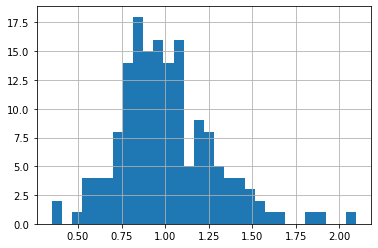

In [47]:
# Validation
df_test = validation_comparison(df_test)

# View predict distribution
print(df_test['predict'].value_counts())
df_test['predict_prob'].hist(bins=30)

In [48]:
# From the above, this can be calculated as follows:
print('Number of data points not predicted: {}'.format(int(len(df_test[df_test['predict_prob'].isnull()]))))
print('Number of data points predicted: {}'.format(int(len(df_test[~df_test['predict_prob'].isnull()]))))

# Measure accuracy
df_test_pred = df_test[~df_test['predict_prob'].isnull()]
print('Accuracy: {}%'.format(np.round(100 * len(df_test_pred[df_test_pred['predict'] == df_test_pred['actual']]) / len(df_test_pred), 2)))

Number of data points not predicted: 5359
Number of data points predicted: 161
Accuracy: 85.71%


# Conclusion

**Recap**<br>
The main issue to tackle is to provide personalised recommendations to the customers that visit Olist platform. There can be 2 types of customers, new customers and existing customers. New customers will be fed popularity-based recommendations, to share the most popular products on the platform, as the customer's preference is not known yet due to lack of purchase history. For existing customers, collaborative filtering can be used by suggesting products based on other similar products or similar customers' purchase history. Another more advance method is to use Funk SVD to uncover latent factors that other customers consider based on purchase history to recommend similar products that existing customers might be interested in.<br>

**Challenges**<br>
One particular challenge was to create large matrices due to hardware limitations. This was overcome by only selecting top 3 product categories to reduce dataset size. Another viable option to overcome this is to install pandas version 0.21 as it surpresses such warning or limitation.<br>

**Improvements**<br>
There are other possible recommendation systems such as associative mining and model-based solutions that might be helpful. These methods can be used together with those included in this project in a hybrid manner to better provide personalised recommendations to Olist customers.